# Exercise 1
-Read fits files
-Create new image in counts
-compute sky background sigma
-detect sources above xSigma
-show images with circled detections
-compute aperture photometry of these sources (on image in nanomaggies)
-transform aperture flux to magnitude
-match g,r,i sources and compute colors(g-r,g-i)
-Plot color magnitude diagrams

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.stats import mad_std
from matplotlib.colors import LogNorm
import copy
#Aperture Photometry
from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture
#PSF photometry
#from photutils.psf import DAOPhotPSFPhotometry, IntegratedGaussianPRF, DAOGroup, BasicPSFPhotometry
#from photutils.background import MMMBackground

In [2]:
#Import Images
image_file_g = ("Pal5-g-SDSS.fits")
image_file_i = ("Pal5-i-SDSS.fits")
image_file_r = ("Pal5-r-SDSS.fits")
#fits.info(image_file_g)
#fits.info(image_file_i)
#fits.info(image_file_r)

In [3]:
image_g = fits.getdata(image_file_g, ext=0)
image_i = fits.getdata(image_file_i, ext=0)
image_r = fits.getdata(image_file_r, ext=0)

In [4]:
#Convert into counts because of poisson statistic
ggain= 1/fits.getval("Pal5-g-SDSS.fits","NMGY")
rgain= 1/fits.getval("Pal5-r-SDSS.fits","NMGY")
igain= 1/fits.getval("Pal5-i-SDSS.fits","NMGY")
image_r *= rgain
image_g *= ggain
image_i *= igain

In [5]:
#Compute skybackground
#Find stars above threshold
gskysig = mad_std(image_g)#Background sigma
gdaofind = DAOStarFinder(fwhm=5.,threshold=10.*gskysig)#Find stars above 10 sigma threshold
gsources = gdaofind(image_g)
for col in gsources.colnames:
    gsources[col].info.format = "%.8g" #consistant table output

rskysig = mad_std(image_r)
rdaofind = DAOStarFinder(fwhm=5.,threshold=10.*rskysig)
rsources = rdaofind(image_r)
for col in rsources.colnames:
    rsources[col].info.format = "%.8g"

iskysig = mad_std(image_i) #gimage
idaofind = DAOStarFinder(fwhm=5.,threshold=10.*iskysig)
isources = idaofind(image_i)
for col in isources.colnames:
    isources[col].info.format = "%.8g"
    
#print(gsources)
#print(isources)
#print(rsources)

In [6]:
gpositions=(gsources["xcentroid"],gsources["ycentroid"])
rpositions=(rsources["xcentroid"],rsources["ycentroid"])
ipositions=(isources["xcentroid"],isources["ycentroid"])

gapertures=CircularAperture(gpositions, r=5.0)
rapertures=CircularAperture(rpositions, r=5.0)
iapertures=CircularAperture(ipositions, r=5.0)

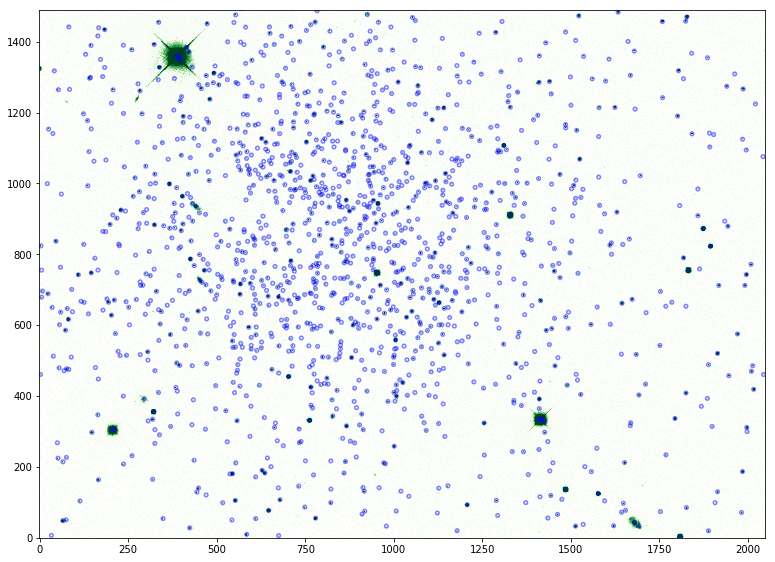

In [7]:
#Circled detections for GREEN
fig, ax = plt.subplots(figsize=(13,10))
ax.imshow(image_g, origin="lower", norm = LogNorm(vmin =20, vmax = 100), cmap="Greens")
gapertures.plot(color="blue", lw=1.5, alpha=0.5)

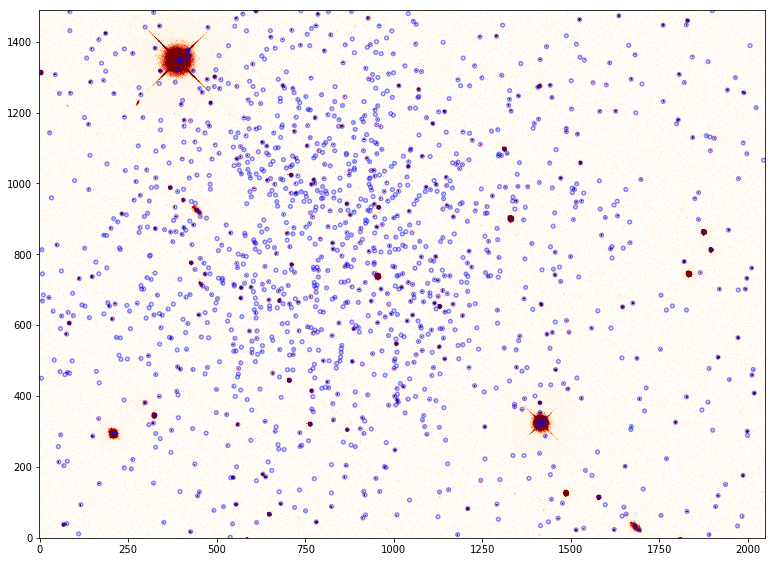

In [8]:
#Circled detections for RED
fig, ax = plt.subplots(figsize=(13,10))
ax.imshow(image_r, origin="lower", norm = LogNorm(vmin =29, vmax = 100), cmap="OrRd")
rapertures.plot(color="blue", lw=1.5, alpha=0.5)

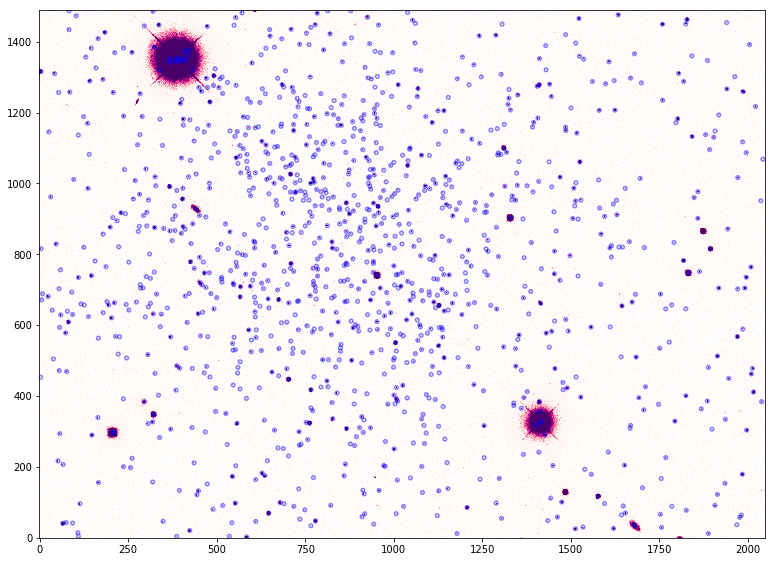

In [9]:
#Circled detections for NEAR INFRARED
fig, ax = plt.subplots(figsize=(13,10))
ax.imshow(image_i, origin="lower", norm = LogNorm(vmin =29, vmax = 100), cmap="RdPu")
iapertures.plot(color="blue", lw=1.5, alpha=0.5)

In [10]:
#Get rid of the stars which are not in every image
g_positions_new = [[],[]]
for i in range(len(gpositions[0])):
    if (gpositions[0][i] > 2064) or (gpositions[1][i] < 12):
        continue
    else:
        g_positions_new[0] += [gpositions[0][i]]
        g_positions_new[1] += [gpositions[1][i]]

#Alignment of the images
ipositions = copy.deepcopy(g_positions_new)
rpositions = copy.deepcopy(g_positions_new)
for i in range(len(ipositions[1])):
    ipositions[1][i] = ipositions[1][i]-10
    ipositions[0][i] = ipositions[0][i]+2
    rpositions[1][i] = rpositions[1][i]-7

In [11]:
#Adjust apertures to chosen stars
rapertures=CircularAperture(rpositions, r=5.0)
iapertures=CircularAperture(ipositions, r=5.0)
gapertures=CircularAperture(g_positions_new, r=5.0)

In [12]:
#Images again in nanomaggies
image_g = fits.getdata(image_file_g, ext=0)
image_i = fits.getdata(image_file_i, ext=0)
image_r = fits.getdata(image_file_r, ext=0)

In [13]:
#Aperture flux
g_phot_table = aperture_photometry(image_g, gapertures)
r_phot_table = aperture_photometry(image_r, rapertures)
i_phot_table = aperture_photometry(image_i, iapertures)

for col in g_phot_table.colnames:
    g_phot_table[col].info.format = "%.8g"
for col in r_phot_table.colnames:
    r_phot_table[col].info.format = "%.8g"
for col in i_phot_table.colnames:
    i_phot_table[col].info.format = "%.8g"

#print(g_phot_table)
#print(r_phot_table)
#print(i_phot_table)
#Colum "aperture_sum" gives flux

In [14]:
#Flux f in nanomaggies to Pogson magnitude m:
#m = [22.5mag] - 2.5*Log10[f]
#http://www.sdss3.org/dr8/algorithms/magnitudes.php

for length in range(0,len(g_phot_table)):
    g_phot_table[length][3] = 22.5-2.5*np.log10(g_phot_table[length][3])
for length in range(0,len(r_phot_table)):
    r_phot_table[length][3] = 22.5-2.5*np.log10(r_phot_table[length][3])
for length in range(0,len(i_phot_table)):
    i_phot_table[length][3] = 22.5-2.5*np.log10(i_phot_table[length][3])

In [15]:
#Colum aperture_sum gives magnitude in mag

#print(g_phot_table)
#print(r_phot_table)
#print(i_phot_table)

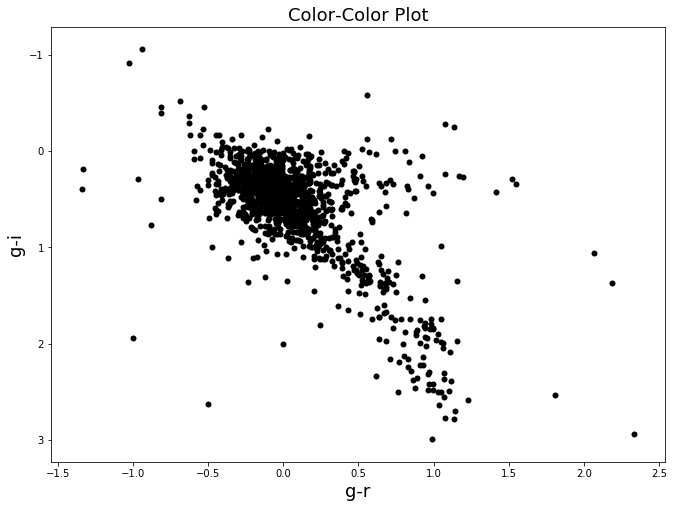

In [16]:
#Color-Color Plot
fig, axes = plt.subplots(figsize=(11,8))
for length in range(len(g_phot_table)):
    x=g_phot_table[length][3]-r_phot_table[length][3]
    y=g_phot_table[length][3]-i_phot_table[length][3]
    axes.scatter(x,y,c="k", linewidths=0.001, edgecolors="w")
axes.invert_yaxis()
axes.set_xlabel('g-r', fontsize=18)
axes.set_ylabel('g-i', fontsize=18)
axes.set_title('Color-Color Plot', fontsize=18);

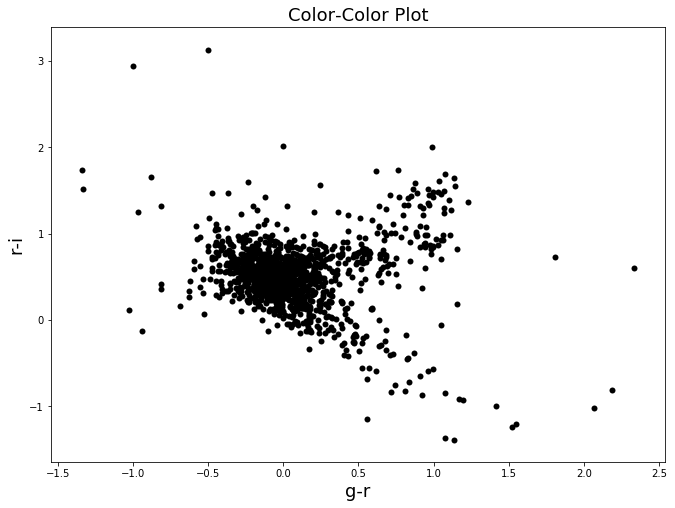

In [17]:
#Color-Color Plot
fig, axes = plt.subplots(figsize=(11,8))
for length in range(len(g_phot_table)):
    x=g_phot_table[length][3]-r_phot_table[length][3]
    y=r_phot_table[length][3]-i_phot_table[length][3]
    axes.scatter(x,y,c="k", linewidths=0.001, edgecolors="w")
#axes.invert_yaxis()
axes.set_xlabel('g-r', fontsize=18)
axes.set_ylabel('r-i', fontsize=18)
axes.set_title('Color-Color Plot', fontsize=18);